In [1]:
from langchain_core.runnables import RunnableConfig
from langchain.schema import AIMessage
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from fpdf import FPDF
import random
import pdfplumber
import warnings
import dotenv

warnings.filterwarnings("ignore")
dotenv.load_dotenv()

True

In [2]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "Tool Call Result"]

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [4]:
@tool
def read_pdf(file_path: str) -> str:
    """
    PDF 파일에서 텍스트를 추출하는 도구입니다.
    표 형식 또는 일반 텍스트가 포함된 PDF를 읽고 문자열로 반환합니다.
    
    file_path 예시: './files/report.pdf'
    """
    try:
        text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text.strip() if text.strip() else "❌ PDF에서 텍스트를 추출할 수 없습니다."
    except Exception as e:
        return f"❌ PDF 읽기 오류: {str(e)}"

In [5]:
@tool
def write_pdf(content: str, filename: str = "output.pdf"):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """
    
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "C:\Windows\Fonts\MALGUN.TTF"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("malgun", "", font_path, uni=True)
        pdf.set_font("malgun", size=12)
    except:
        raise ValueError("한글 폰트가 존재하지 않습니다.")
    
    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./files/{filename}")

    print(f"PDF saved as ./files/{filename}")

    return {"content":content, "filename":filename}

In [ ]:
# TavilySearchResults : 웹 검색 도구
# PythonAstREPLTool : 파이썬 코드 실행 도구
# write_pdf : pdf 생성 도구
# read_pdf : pdf 읽기 도구
# file_delete : 파일 삭제 도구
# list_directory : 파일 목록 읽기 도구

tools = [TavilySearchResults(include_domains=["naver.com", "google.com", "youtube.com"]), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(root_dir="./files/",
                                                                            selected_tools=["file_delete","list_directory"]).get_tools()]
search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [222]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [223]:
def shorterm_memory(state:State):

    if len(state["messages"]) > 4:
        history = state["messages"][-4:-1]
    elif len(state["messages"]) == 1:
        history = ""
    else:
        history = state["messages"][:-1]

    return history

In [224]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | history_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                            "query":state["query"]})

    return result.yes_no

In [225]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    
    chain = prompt | llm

    history = shorterm_memory(state)

    answer = chain.invoke({"history":history,
                           "query":state["query"]})
    
    if len(state["tool_call"]) == 0:
        return {"answer":answer.content,
                "messages":answer,
                "tool_call":"사용된 기록 없음."}
    else:
        return {"answer":answer.content,
                "messages":answer}

In [226]:
history_checker = llm.with_structured_output(HistoryChecker)

In [227]:
def history_node(state:State):
    if len(state["messages"]) == 1:
        return {"answer":"답변 없음",
                "tool_call":"사용된 도구 없음"}
    else:
        return state

In [228]:
def select(
    state: State,
):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                최근에 사용한 도구가 있다면 도구도 참고하세요. 다른 도구를 사용하는 것이 더 좋은 방법이 될 수 있습니다.
                                                    
                대화 기록 : {history}     
                                          
                최근 사용한 도구 : {tool_name}
                                        
                정답 : {answer}
                                        
                질문 : {query}
                                          
                """)

    chain = prompt | llm_with_tools

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                           "tool_name" : state["tool_call"],
                            "answer": state["answer"],
                            "query": state["query"]})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls
        return {"messages": result,
                "tool_call": [result]}
    else:
        return {"messages":AIMessage(content=f"""도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
                                        """),
                                    "tool_call":None}

    

In [229]:
tool_node = ToolNode(tools)

In [230]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.
    
    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """


    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")    

In [231]:
answer_checker = llm.with_structured_output(AnswerChecker)

In [232]:
def response(state:State):

    return {"answer":state["messages"][-1]}

In [233]:
def answer_check(state:State):

    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기 어시스턴트트입니다.
    
    정답이 질문을 해결할 수 있는지 여부를 판단합니다.
    질문을 해결할 수 없다면 도구를 이용합니다.

    질문을 해결할 수 있다면 "end", 아니라면 "tool"을 반환합니다.
                                          
    기존 History도 참고하여 답변하세요.
                                          
    History : {history}
                            
    정답 : {answer}
                            
    질문 : {query}
    """)

    chain = prompt | answer_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                            "answer": state["answer"],
                            "query": state["query"]})
    
    return result.end

In [234]:
graph_builder = StateGraph(State)

In [235]:
graph_builder.add_node("history_node", history_node)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "response")
graph_builder.add_edge("memory_chat", "response")
graph_builder.add_conditional_edges("response",
                                    answer_check,
                                    {"end":END,
                                    "tool":"select"});

In [236]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [237]:
def reset_config(limit=20):

    thread_id=random.randint(1,999999)

    config = RunnableConfig(recursion_limit=limit, configurable={"thread_id": thread_id})

    return config

In [238]:
config = reset_config()

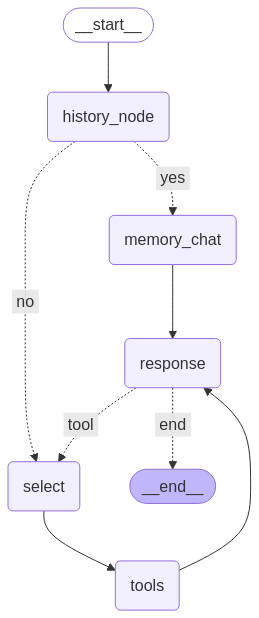

In [164]:
graph

In [239]:
def streaming(query, config):

    result = graph.stream({"messages":("user", query),
                         "query":query}, config=config)
    for step in result:
        for k, v in step.items():
            print(f"\n\n=== {k} ===\n\n")
            try:
                print(v)
            except:
                pass
    
    return 

In [240]:
query = "1+1은 뭔가요?"

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== memory_chat ===


{'answer': '1+1은 2입니다.', 'messages': AIMessage(content='1+1은 2입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 78, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bbfba58e46', 'finish_reason': 'stop', 'logprobs': None}, id='run-bee41725-7fd1-4d96-b2f3-ff651e0ca7f2-0', usage_metadata={'input_tokens': 78, 'output_tokens': 9, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


=== response ===


{'answer': AIMessage(content='1+1은 2입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': 

In [241]:
query = "피엔티에 대해 조사해서 레포트 작성해주세요. pdf형태로 저장해주세요."

streaming(query, config)



=== history_node ===


{'query': '피엔티에 대해 조사해서 레포트 작성해주세요. pdf형태로 저장해주세요.', 'answer': AIMessage(content='1+1은 2입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 78, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bbfba58e46', 'finish_reason': 'stop', 'logprobs': None}, id='run-bee41725-7fd1-4d96-b2f3-ff651e0ca7f2-0', usage_metadata={'input_tokens': 78, 'output_tokens': 9, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'messages': [HumanMessage(content='1+1은 뭔가요?', additional_kwargs={}, response_metadata={}, id='8f462111-46d2-4d4a-bf37-be279cb54d9d'), AIMessage(content='1+1은 2입니다.', additional_k

In [242]:
query = "피엔티_레포트.pdf 파일 삭제해줘"

streaming(query, config)



=== history_node ===


{'query': '피엔티_레포트.pdf 파일 삭제해줘', 'answer': ToolMessage(content='{"content": "# 피엔티(PNT) 레포트\\n\\n## 1. 기업 개요\\n피엔티는 고도의 기술을 요구하는 박막화에 특화된 이차전지용 소재 및 전지박 등을 생산하는 장비를 주로 생산하는 기업입니다. 이 회사는 Roll-to-Roll 기술을 기반으로 하여 새로운 기능을 부가하는 공법을 통해 성장하고 있습니다.\\n\\n## 2. 주요 기술 및 제품\\n- **Roll-to-Roll 기술**: 이 기술은 모재를 회전롤에 감으면서 소정의 물질을 도포하여 새로운 기능을 부가하는 공법입니다.\\n- **이차전지용 소재**: 피엔티는 이차전지의 핵심 소재를 생산하여 배터리 제조 비용 절감에 기여하고 있습니다.\\n\\n## 3. 최근 동향\\n피엔티는 2025년까지 55명의 인력 충원과 1000억원의 투자를 통해 구미 하이테크밸리에 양극활물질 양산 공장을 건설할 계획입니다. 이를 통해 밸류체인을 구축하고 경쟁력을 강화할 예정입니다.\\n\\n## 4. 주가 전망\\n피엔티는 이차전지 장비주 대장주로서, 셀 업체들과의 협력을 통해 지속적인 성장이 기대됩니다.\\n\\n## 5. 참고 자료\\n- [(종목공부) 피엔티 : 네이버 블로그](https://blog.naver.com/mindy0103/223349748240?viewType=pc)\\n- [피엔티 주가 전망 2차전지장비주 대장주, 셀 업체들과 다른 ...](https://blog.naver.com/nasiba5083/223506860190?viewType=pc)\\n- [피엔티 주가 전망; 피엔티머티리얼즈에 무슨 일이? - 네이버블로그](https://blog.naver.com/make_money_big/223563063299?fromRss=true&trackingCode=rss)\\n- [보유종목점검 - 1. 피엔티 : 네이버 블로그](https:

In [243]:
config = reset_config()

streaming("pda1.pdf파일 읽어줘", config=config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lsRs63uY9YJDvZ6VkNOmkbVM', 'function': {'arguments': '{"file_path":"./files/pda1.pdf"}', 'name': 'read_pdf'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 446, 'total_tokens': 467, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_27322b4e16', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f40d8cb4-5f68-45e0-8bdf-fbb18bd056ef-0', tool_calls=[{'name': 'read_pdf', 'args': {'file_path': './files/pda1.pdf'}, 'id': 'call_lsRs63uY9YJDvZ6VkNOmkbVM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 446, 'output_tokens':

In [244]:
query = "개강하는 날짜는 언제인가요?"

streaming(query, config)



=== history_node ===


{'query': '개강하는 날짜는 언제인가요?', 'answer': ToolMessage(content='아이펠 프로덕트 데이터 분석가 기\n1\n해당 사업은 K\ue088Digital Training의 일환으로 고용노동부에서 주관하고 있습니다.\n저희는 모두의연구소 아이펠캠퍼스팀이며 해당 훈련을 운영하고 있습니다.\n아이펠이란\n?\n아이펠은 누구나 인공지능을 학습할 수 있도록 설계된 교육 프로그램으로 코어, 리서치, 데이터사이언\n티스트, 프로덕트 데이터 분석가 과정 등이 있습니다.\n코어 과정에서는 인공지능 모델 제작 및 어플리케이션 제작까지 진행하게 됩니다.\n리서치 과정에서는 대학원 수준의 인공지능 지식을 배울 수 있고 논문을 작성할 수 있는 수준까지 학습\n하게 됩니다.\n데이터 사이언티스트 과정은 실무 기반의 과정으로 데이터 분석, 머신러닝 및 딥러닝 모델 제작까지 담\n당하며 이를 통해 비즈니스 인사이트를 도출하는 방법 등을 배우게 됩니다.\n프로덕트 데이터 분석가 과정은 마케팅 지표 분석, BI툴 활용, 통계 분석, 데이터 분석 등을 배우며 기\n업의 비즈니스 의사결정에 기여하는 방법을 배우게 됩니다.\n개요\n모두의연구소 프로덕트 데이터 분석가 과정\n실무 기반 프로젝트로 학습하고 현직자 세미나로 이론과 실무를, 현업 멘토와 포트폴리오 완성까지!\n교육명\n모두의연구소 아이펠 프로덕트 데이터 분석가 과정 1기\n모집 기간\n2024. 11. 18 - 2024. 12. 24, 약 1달간 모집 예정입니다.\n교육 기간\n2024. 12. 30 - 25. 06. 26, 약 6개월이며 120일 과정입니다.\n교육 시간\n평일 10:00 - 18:00, 주말은 운영하지 않습니다.\n교육 환경\n아이펠 프로덕트 데이터 분석가 1기 1\n100% 실시간 온라인 과정 (타 KDT훈련 및 직장 병행 불가)\n홈페이지\n모두의연구소 링크 (modulabs.co.kr)\n아이펠 데이터사이언티스트 과정 링크 (http

In [245]:
query = "강의는 어디서 들을 수 있나요?"

streaming(query, config)



=== history_node ===


{'query': '강의는 어디서 들을 수 있나요?', 'answer': AIMessage(content='개강 날짜는 2024년 12월 30일입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 3507, 'total_tokens': 3524, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bbfba58e46', 'finish_reason': 'stop', 'logprobs': None}, id='run-5a5e0b8b-c478-4240-84e7-3fce4e4691be-0', usage_metadata={'input_tokens': 3507, 'output_tokens': 17, 'total_tokens': 3524, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'messages': [HumanMessage(content='pda1.pdf파일 읽어줘', additional_kwargs={}, response_metadata={}, id='15d651f3-cb44-4a65-8a7a-a386343ee075'), AIMessage(content='', additional_kwar

In [246]:
config = reset_config()

code = """
아래 코드 실행시켜주세요.

```python
result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i)
    result += i

print("최종 결과: ", result)

```
"""

streaming(code, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V14leIZnpkbboUi80MmThjD6', 'function': {'arguments': '{"query":"result = 0\\n\\nfor i in range(20):\\n    print(f\\"{i+1}번째 출력: \\", i)\\n    result += i\\n\\nprint(\\"최종 결과: \\", result)"}', 'name': 'python_repl_ast'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 491, 'total_tokens': 555, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_27322b4e16', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-33221ace-7248-400d-8061-21dd5c1b7e56-0', tool_calls=[{'name': 'python_repl_ast', 'args': {'query': 'result = 0\n\nfor i in

In [248]:
config = reset_config()

streaming("""모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.""", config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bwZ2r5fgXMffJSOS0fhaWe2i', 'function': {'arguments': '{"query":"모두의연구소"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 500, 'total_tokens': 524, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_27322b4e16', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-25e8af38-49f1-4d03-a817-49b56382f93e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '모두의연구소'}, 'id': 'call_bwZ2r5fgXMffJSOS0fhaWe2i', 'type': 'tool_call'}], usage_metadata={'input_tokens': 500, 'output_